In [35]:
import numpy as np
from scipy.optimize import fsolve, brentq
from scipy.linalg import lu
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 
from math import sin,cos,pi 

In [36]:
# Define the function for which we want to find the root
def radar_interference_func(theta, C):
  """
  Menghitung nilai fungsi untuk persamaan akar interferensi radar.

  Persamaan f(theta) = C * sin(theta) + pi = 0,
  dimana C = lambda * R / (4 * pi * ht * hr).

  Args:
    theta: sudut dalam bentuk radian.
    C: Istilah konstanta yang berasal dari parameter radar.

  Returns:
    Nilai fungsi f(theta).
  """
  return C * np.sin(theta) + np.pi

In [37]:
# --- Bisection Method Implementation ---
def bisection_method_table(func_to_solve, C_val, a, b, true_root=None, tol=1e-6, max_iter=100):
  """
  Penyelesaian func_to_solve(theta, C_val) = 0 menggunakan bisection method
  dan returns iteration history.

  Args:
    func_to_solve: Fungsi untuk mencari akar dari (e.g., radar_interference_func).
                   Harus menerima 2 argumen: theta and C_val.
    C_val: Konstanta C yang spesifik untuk contoh masalah.
    a: Permulaan interval awal.
    b: Akhir dari interval awal.
    true_root: Akar sebenarnya yang diketahui, jika tersedia, untuk penghitungan kesalahan (opsional).
    tol: toleransi yang di gunakan |b-a|/2 or abs(f(c)).
    max_iter: Maximum iterasi.
  """
  rows = []
  midpoints = [] 
  fa = func_to_solve(a, C_val)
  fb = func_to_solve(b, C_val)

  if fa * fb >= 0:
    print(f"Error: Function does not change sign on the interval [{a}, {b}].")
    print(f"f({a}) = {fa:.6f}")
    print(f"f({b}) = {fb:.6f}")
    return None, None 

  iteration = 0
  print("--- Bisection Method Iterations ---")
  print(f"{'Iter':<5} {'a':<13} {'b':<13} {'c':<13} {'f(c)':<13} {'ApproxRelErr(%)':<18} {'TrueRelErr(%)':<18}")
  print("-" * 95)

  while iteration < max_iter:
    c = a + (b - a) / 2.0
    fc = func_to_solve(c, C_val)
    midpoints.append(c)

    # Menghitung error 
    approx_rel_error = None
    if iteration > 0:
        if abs(c) > np.finfo(float).eps:
            approx_rel_error = abs((c - midpoints[-2]) / c) * 100
        else:
            approx_rel_error = float('inf')

    true_rel_error = None
    if true_root is not None:
        if abs(true_root) > np.finfo(float).eps:
             true_rel_error = abs((c - true_root) / true_root) * 100
        elif abs(c - true_root) < tol: 
             true_rel_error = 0.0
        else:
             true_rel_error = float('inf') 

    row_data = {
        "Iteration": iteration + 1, 
        "a": a,
        "b": b,
        "c": c,
        "f(c)": fc,
        "ApproxRelErr(%)": approx_rel_error,
        "TrueRelErr(%)": true_rel_error
    }
    rows.append(row_data)

    # Print current iteration (optional, can make it long for many iterations)
    print(f"{row_data['Iteration']:<5} {a:<13.6f} {b:<13.6f} {c:<13.6f} {fc:<13.3e} "
          f"{approx_rel_error if approx_rel_error is not None else 'N/A':<18} "
          f"{true_rel_error if true_rel_error is not None else 'N/A':<18}")


    # Periksa kriteria penghentian
    # Berhenti jika nilai fungsi titik tengah mendekati nol atau interval cukup kecil
    if abs(fc) < tol or abs(b - a) / 2.0 < tol:
        print("-" * 95)
        print(f"Converged after {iteration + 1} iterations.")
        history_df = pd.DataFrame(rows)
        return c, history_df 

    # Update interval
    if fa * fc < 0:
      b = c
    else:
      a = c
      fa = fc 
    iteration += 1

  print("-" * 95)
  print(f"Failed to converge within {max_iter} iterations.")
  history_df = pd.DataFrame(rows)
  return c, history_df 

In [38]:
# --- Plotting Function ---
def plot_bisection_history(df_history, true_root=None):
    if df_history is None or df_history.empty:
        print("No data to plot.")
        return

    iterations = df_history['Iteration']
    a_vals = df_history['a']
    b_vals = df_history['b']
    c_vals = df_history['c']
    fc_vals = df_history['f(c)']
    approx_err = df_history['ApproxRelErr(%)']
    true_err = df_history['TrueRelErr(%)']

    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
    fig.suptitle('Bisection Method Convergence Analysis', fontsize=16)

    # --- Plot 1: Root Approximation and Interval Bounds ---
    axs[0].plot(iterations, c_vals, 'o-', label='Root Approximation (c)', color='red', markersize=5)
    axs[0].plot(iterations, a_vals, '--', label='Lower Bound (a)', color='blue', alpha=0.7)
    axs[0].plot(iterations, b_vals, '--', label='Upper Bound (b)', color='green', alpha=0.7)
    if true_root is not None:
        axs[0].axhline(true_root, color='black', linestyle=':', label=f'True Root ({true_root:.6f})')
    axs[0].set_ylabel('Theta (radians)')
    axs[0].set_title('Root Approximation and Interval Bounds vs. Iteration')
    axs[0].legend()
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot 2: Absolute Function Value at Midpoint ---
    # Menghitung nilai absolut, menangani potensi nol untuk skala log
    abs_fc = np.abs(fc_vals)
     # Ganti angka nol dengan angka yang sangat kecil untuk menghindari masalah log(0), atau lewati plottingnya
    abs_fc[abs_fc < np.finfo(float).eps] = np.nan # Mark small values as NaN to skip plotting
    axs[1].plot(iterations, abs_fc, 'o-', label='|f(c)|', color='purple')
    axs[1].set_yscale('log') # Use logarithmic scale for better visualization
    axs[1].set_ylabel('|f(c)| (Log Scale)')
    axs[1].set_title('Absolute Function Value at Midpoint vs. Iteration')
    axs[1].legend()
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot 3: Relative Errors ---
    # Skip first iteration for approximate error if it's None
    iterations_err = iterations[approx_err.notna()]
    approx_err_plot = approx_err.dropna()
    true_err_plot = true_err[approx_err.notna()] # Align true error plotting

    if not approx_err_plot.empty:
        axs[2].plot(iterations_err, approx_err_plot, 'o-', label='Approx. Relative Error (%)', color='orange')
    if true_root is not None and not true_err_plot.empty:
        axs[2].plot(iterations_err, true_err_plot, 'x-', label='True Relative Error (%)', color='cyan')

    axs[2].set_yscale('log') # Use logarithmic scale
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Relative Error (%) (Log Scale)')
    axs[2].set_title('Relative Errors vs. Iteration')
    axs[2].legend()
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
    plt.show()

In [39]:
# --- Parameter dan Eksekusi ---

# !! PENTING: Ganti ini dengan nilai C yang telah Anda hitung !!
# C = lambda_val * R_val / (4 * np.pi * ht_val * hr_val)
C_actual = 2 * np.pi # Menggunakan nilai placeholder untuk demonstrasi

# Interval awal [a, b]
# !! PENTING: Pastikan bahwa func_to_solve(a, C_aktual) dan func_to_solve(b, C_aktual) memiliki tanda yang berlawanan !!
a_interval = -1.0
b_interval = 0.0

# Parameter lainnya
tolerance = 1e-6
max_iterations = 100
# Berikan akar sebenarnya jika diketahui, jika tidak, setel ke Tidak Ada
true_root_val = -0.523598826

In [40]:
print(f"Solving f(theta) = C * sin(theta) + pi = 0")
print(f"Using C = {C_actual:.6f}")
print(f"Initial interval [a, b] = [{a_interval:.6f}, {b_interval:.6f}]")
print(f"Tolerance = {tolerance}, Max Iterations = {max_iterations}")

Solving f(theta) = C * sin(theta) + pi = 0
Using C = 6.283185
Initial interval [a, b] = [-1.000000, 0.000000]
Tolerance = 1e-06, Max Iterations = 100


In [41]:
approx_root, df_history = bisection_method_table(
    radar_interference_func,
    C_actual,
    a_interval,
    b_interval,
    true_root=true_root_val,
    tol=tolerance,
    max_iter=max_iterations
)

--- Bisection Method Iterations ---
Iter  a             b             c             f(c)          ApproxRelErr(%)    TrueRelErr(%)     
-----------------------------------------------------------------------------------------------
1     -1.000000     0.000000      -0.500000     1.293e-01     N/A                4.507043337029935 
2     -1.000000     -0.500000     -0.750000     -1.141e+00    33.33333333333333  43.239434994455095
3     -0.750000     -0.500000     -0.625000     -5.347e-01    20.0               19.36619582871258 
4     -0.625000     -0.500000     -0.562500     -2.092e-01    11.11111111111111  7.429576245841322 
5     -0.562500     -0.500000     -0.531250     -4.154e-02    5.88235294117647   1.461266454405694 
6     -0.531250     -0.500000     -0.515625     4.349e-02     3.0303030303030303 1.5228884413121206
7     -0.531250     -0.515625     -0.523438     8.776e-04     1.4925373134328357 0.0308109934532133
8     -0.531250     -0.523438     -0.527344     -2.036e-02    0.7407

-----------------------------------------------------------------------------------------------
Converged: Yes
Approximate root found: -0.523598671
Number of iterations: 20

Iteration History Table:


,Iteration,a,b,c,f(c),ApproxRelErr(%),TrueRelErr(%)
0,1,-1,0,-0.5,0.129273,NaN,4.50704
1,2,-1,-0.5,-0.75,-1.14127,33.3333,43.2394
2,3,-0.75,-0.5,-0.625,-0.534682,20,19.3662
3,4,-0.625,-0.5,-0.5625,-0.209247,11.1111,7.42958
4,5,-0.5625,-0.5,-0.53125,-0.041541,5.88235,1.46127
5,6,-0.53125,-0.5,-0.515625,0.0434879,3.0303,1.52289
6,7,-0.53125,-0.515625,-0.523438,0.000877606,1.49254,0.030811
7,8,-0.53125,-0.523438,-0.527344,-0.0203558,0.740741,0.715228
8,9,-0.527344,-0.523438,-0.525391,-0.00974512,0.371747,0.342208
9,10,-0.525391,-0.523438,-0.524414,-0.00443526,0.18622,0.155699



Final True Relative Error: 0.000030%

Generating convergence plots...


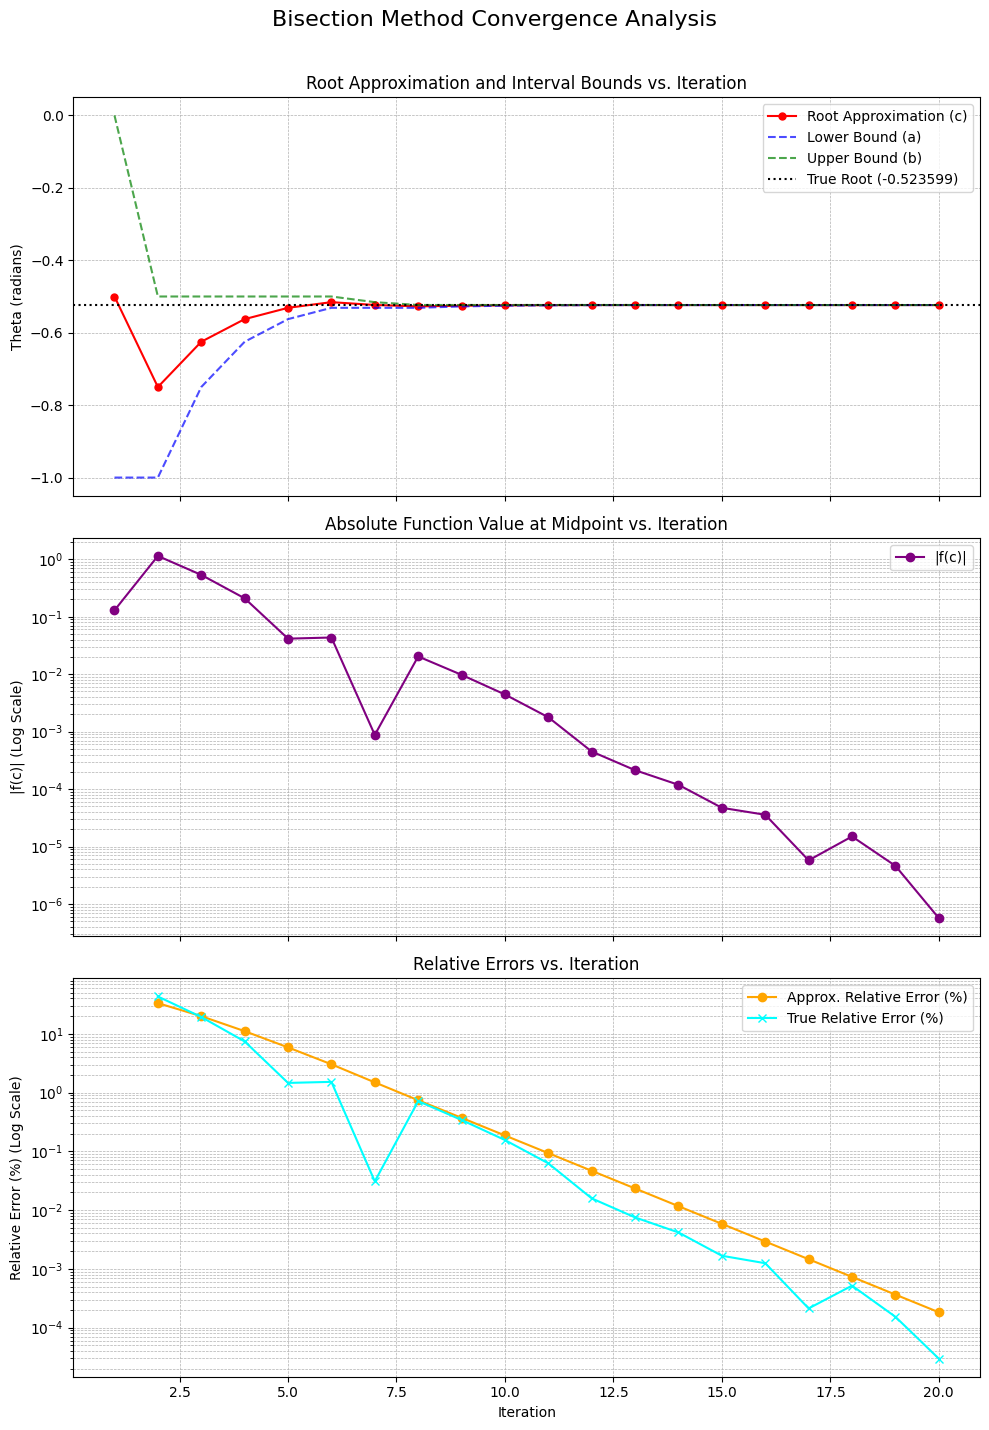

In [42]:
# --- Display Results ---
if approx_root is not None:
  print("-" * 95) # Separator after calculation
  print(f"Converged: {'Yes' if df_history is not None and df_history.iloc[-1]['Iteration'] < max_iterations else 'No (Max Iter Reached)'}")
  print(f"Approximate root found: {approx_root:.9f}")
  print(f"Number of iterations: {len(df_history) if df_history is not None else 'N/A'}")
  print("\nIteration History Table:")
  pd.set_option('display.float_format', '{:.6g}'.format)
  pd.set_option('display.max_rows', 100)
  display(df_history) # Use display() if in a notebook environment, otherwise print()

  if true_root_val is not None:
      final_true_error = abs((approx_root - true_root_val) / true_root_val) * 100 if abs(true_root_val) > 1e-12 else abs(approx_root - true_root_val)
      print(f"\nFinal True Relative Error: {final_true_error:.6f}%")

  # --- Generate Plots ---
  print("\nGenerating convergence plots...")
  plot_bisection_history(df_history, true_root=true_root_val)

else:
  print("\nBisection method failed to find a root (Initial interval invalid).")

In [53]:
lambda_fp = 0.15 
def df(theta): 
    return C_actual*cos(theta)  

In [75]:
def table_open(iterates): 
    rows = [] 
    for i, x in enumerate(iterates): 
        if i == 0: 
            approx_error = None 
        else: 
            approx_error = abs(iterates[i]-iterates[i-1]) / abs(iterates[i]) * 100 
        true_error = abs(x - true_root_val) / abs(true_root_val) * 100 
        rows.append({
            "Iteration" : i, 
            "x" : x, 
            "error_a (%)" : approx_error,
            "error_t (&)" : true_error
        })
    return rows 

In [76]:
def newton_raphson(x0): 
    iterates = [x0]
    for i in range(max_iterations): 
        f_val = radar_interference_func(iterates[-1],C_actual)
        df_val = df(iterates[-1]) 
        if df_val == 0: 
            raise ZeroDivisionError("Turunan sama dengan 0") 
        x_new = iterates[-1] - f_val / df_val 
        iterates.append(x_new)
        if abs(radar_interference_func(x_new,C_actual)) < tolerance or abs(x_new - iterates[-2]) < tolerance: 
            break
    return iterates 

In [78]:
x0_newton = 0.73 
iters_newton = newton_raphson(x0_newton) 
table_newton = table_open(iters_newton) 
df_newton = pd.DataFrame(table_newton) 

In [79]:
display(df_newton) 

,Iteration,x,error_a (%),error_t (&)
0,0,0.73,NaN,239.42
1,1,-0.835901,187.331,59.6454
2,2,-0.475129,75.9315,9.25705
3,3,-0.522976,9.14892,0.119021
4,4,-0.523599,0.11899,3.10115e-05


In [9]:
import numpy as np

def gauss_seidel(A, b, x_init, tol=1e-6, max_iter=100):
    """
    Solves Ax = b using the Gauss-Seidel iterative method.
    
    Parameters:
    A : numpy.ndarray
        Coefficient matrix.
    b : numpy.ndarray
        Right-hand side vector.
    x_init : numpy.ndarray
        Initial guess for the solution.
    tol : float
        Tolerance for convergence.
    max_iter : int
        Maximum number of iterations.
        
    Returns:
    x : numpy.ndarray
        Solution vector.
    """
    n = len(b)
    x = x_init.copy()
    
    for iteration in range(max_iter):
        x_new = x.copy()
        
        for i in range(n):
            sum1 = np.dot(A[i, :i], x_new[:i])  # Using the latest values
            sum2 = np.dot(A[i, i+1:], x[i+1:])  # Using the previous values
            x_new[i] = (b[i] - sum1 - sum2) / A[i, i]
        
        # Check for convergence
        if np.linalg.norm(x_new - x, ord=np.inf) < tol:
            print(f"Converged in {iteration + 1} iterations.")
            return x_new
        
        x = x_new
    
    print("Did not converge within the maximum number of iterations.")
    return x

In [10]:
# Example coefficient matrix A and vector b
A = np.array([[4, -1, 0],
              [-1, 4, -1],
              [0, -1, 3]], dtype=float)

b = np.array([15, 10, 10], dtype=float)

# Initial guess
x_init = np.zeros_like(b)

# Solve using Gauss-Seidel
solution = gauss_seidel(A, b, x_init)

print("Solution:", solution)

Converged in 10 iterations.
Solution: [4.99999992 4.99999995 4.99999998]


In [16]:
# --- System Setup ---
A = np.array([
    [ 2.0,  3.0, -1.0],
    [-1.0, -4.0,  2.0],
    [ 5.0, -2.0,  1.0]
])

b = np.array([-123.37, -98.70, -82.25])


# --- LU Decomposition ---
P, L, U = lu(A)

print("Matrix A:")
print(A)
print("\nPermutation Matrix P:")
print(P)
print("\nLower Triangular Matrix L:")
print(L)
print("\nUpper Triangular Matrix U:")
print(U)

# --- Verify PA = LU ---
PA = P @ A
LU = L @ U
print("\nVerification: PA and LU difference")
print(PA - LU)

# --- Solve Ly = Pb ---
Pb = np.dot(P, b)
y = np.zeros_like(b)

for i in range(len(y)):
    y[i] = Pb[i] - np.dot(L[i, :i], y[:i])

# --- Solve Ux = y ---
x = np.zeros_like(b)

for i in range(len(x)-1, -1, -1):
    x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]

print("\n✅ Final Solution from LU Decomposition:")
print(f"x1 = {x[0]:.6f}, x2 = {x[1]:.6f}, x3 = {x[2]:.6f}")

# --- Direct Solver Comparison ---
x_direct = np.linalg.solve(A, b)
print("\n✅ Solution from np.linalg.solve:")
print(f"x1 = {x_direct[0]:.6f}, x2 = {x_direct[1]:.6f}, x3 = {x_direct[2]:.6f}")

# --- Compare Difference ---
diff = np.abs(x_direct - x)
print("\n🔍 Absolute difference between LU and Direct method:")
print(diff)

# --- Optional: Residual norm ---
residual = np.linalg.norm(A @ x - b)
print("\n📉 Residual norm (||Ax - b||):")
print(residual)


Matrix A:
[[ 2.  3. -1.]
 [-1. -4.  2.]
 [ 5. -2.  1.]]

Permutation Matrix P:
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

Lower Triangular Matrix L:
[[ 1.          0.          0.        ]
 [-0.2         1.          0.        ]
 [ 0.4        -0.86363636  1.        ]]

Upper Triangular Matrix U:
[[ 5.  -2.   1. ]
 [ 0.  -4.4  2.2]
 [ 0.   0.   0.5]]

Verification: PA and LU difference
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

✅ Final Solution from LU Decomposition:
x1 = -5.981818, x2 = -163.747273, x3 = -379.835455

✅ Solution from np.linalg.solve:
x1 = -5.981818, x2 = -163.747273, x3 = -379.835455

🔍 Absolute difference between LU and Direct method:
[0. 0. 0.]

📉 Residual norm (||Ax - b||):
9.099386826154683e-14


In [12]:
def jacobi_iteration(A, b, x0=None, tol=1e-6, max_iterations=100, print_progress=False):
    """
    Solves the linear system Ax = b using the Jacobi iterative method.

    Args:
        A (np.ndarray): The square coefficient matrix (n x n).
        b (np.ndarray): The right-hand side vector (n x 1).
        x0 (np.ndarray, optional): The initial guess for the solution vector.
                                   If None, defaults to zeros. Defaults to None.
        tol (float, optional): The tolerance for convergence. Stops when the
                               infinity norm of the difference between successive
                               iterations is less than tol. Defaults to 1e-6.
        max_iterations (int, optional): The maximum number of iterations allowed.
                                        Defaults to 100.
        print_progress (bool, optional): If True, prints the iteration number
                                         and norm difference. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - x (np.ndarray): The approximate solution vector.
            - iterations (int): The number of iterations performed.
            - converged (bool): True if the method converged within max_iterations,
                                False otherwise.
            - final_diff (float): The final norm difference achieved.
    """
    n = A.shape[0]
    if A.shape[0] != n or A.shape[1] != n:
        raise ValueError("Matrix A must be square.")
    if b.shape[0] != n:
        raise ValueError("Vector b must have the same number of rows as A.")

    # Check for zero diagonal elements
    if np.any(np.diag(A) == 0):
        print("Error: Matrix has zero on the diagonal. Jacobi method cannot proceed.")
        return None, 0, False, np.inf

    # Initialize guess if not provided
    if x0 is None:
        x = np.zeros(n, dtype=float)
    else:
        if x0.shape[0] != n:
             raise ValueError("Initial guess x0 must have the same number of rows as A.")
        x = x0.astype(float) # Ensure float type

    x_new = np.copy(x)
    converged = False
    final_diff = np.inf

    print("--- Jacobi Iteration ---")
    for k in range(max_iterations):
        # Calculate the next iteration based *only* on the previous x
        for i in range(n):
            sigma = 0
            for j in range(n):
                if i != j:
                    sigma += A[i, j] * x[j] # Use previous iteration's x
            x_new[i] = (b[i] - sigma) / A[i, i]

        # Check convergence (infinity norm of the difference)
        final_diff = np.linalg.norm(x_new - x, ord=np.inf)

        if print_progress:
             print(f"Iter {k + 1}: |x_new - x|_inf = {final_diff:.2e}")

        # Update x for the next iteration
        x = np.copy(x_new)

        if final_diff < tol:
            print(f"\nConverged after {k + 1} iterations.")
            converged = True
            break

    if not converged:
        print(f"\nWarning: Failed to converge within {max_iterations} iterations.")
        print(f"Final difference norm: {final_diff:.2e}")

    return x, k + 1, converged, final_diff

In [13]:
# --- System Definition (from user image) ---
A = np.array([
    [ 2.0,  3.0, -1.0],
    [-1.0, -4.0,  2.0],
    [ 5.0, -2.0,  1.0]
])

b = np.array([-123.37, -98.70, -82.25])


In [15]:
# --- Parameters for Iteration ---
initial_guess = np.zeros(A.shape[0]) # Start with zeros
tolerance = 1e-6
max_iterations = 10 # Increase if needed, but convergence not guaranteed

# --- Run Jacobi Iteration ---
solution, iters, converged_status, diff = jacobi_iteration(
    A,
    b,
    x0=initial_guess,
    tol=tolerance,
    max_iterations=max_iterations,
    print_progress=True # Show progress
)

# --- Display Results ---
print("\n--- Results ---")
if solution is not None:
    print(f"Approximate solution x = [x1, x2, x3]:")
    print(solution)
    print(f"Iterations performed: {iters}")
    print(f"Converged within tolerance: {converged_status}")
    print(f"Final difference norm: {diff:.4e}")

    # Optional: Verify the solution by calculating the residual
    residual = b - A @ solution
    print(f"\nResidual vector (b - Ax):")
    print(residual)
    print(f"Norm of residual: {np.linalg.norm(residual):.4e}")

--- Jacobi Iteration ---
Iter 1: |x_new - x|_inf = 8.22e+01
Iter 2: |x_new - x|_inf = 3.58e+02
Iter 3: |x_new - x|_inf = 3.39e+02
Iter 4: |x_new - x|_inf = 6.90e+02
Iter 5: |x_new - x|_inf = 8.71e+02
Iter 6: |x_new - x|_inf = 1.96e+03
Iter 7: |x_new - x|_inf = 3.40e+03
Iter 8: |x_new - x|_inf = 2.83e+03
Iter 9: |x_new - x|_inf = 1.07e+04
Iter 10: |x_new - x|_inf = 1.28e+04

Final difference norm: 1.28e+04

--- Results ---
Approximate solution x = [x1, x2, x3]:
[ 4313.42229919  5308.34141388 -1931.30487915]
Iterations performed: 10
Converged within tolerance: False
Final difference norm: 1.2827e+04

Residual vector (b - Ax):
[-26606.54371918  29310.69771301  -9101.37378906]
Norm of residual: 4.0618e+04


In [17]:
# Check if the matrix is diagonally dominant
def check_diaDom(A):
    n = len(A)
    
    for i in range(n):
        diag_val = abs(A[i][i])
        row_sum = sum(abs(A[i][j]) for j in range(n) if j != i)
        
        if diag_val < row_sum:
            return False  # Not diagonally dominant
    
    return True  # Matrix is diagonally dominant

# Gauss-Seidel Method Implementation
def GS_method(A, b, x_init, max_iterations=100, tolerance=1e-10):
    n = len(A)
    x = x_init.copy()  # Create a copy to avoid modifying the input
    
    for iteration in range(max_iterations):
        x_old = x.copy()
        
        for i in range(n):
            # Calculate sum of off-diagonal elements * current x values
            sum1 = sum(A[i][j] * x[j] for j in range(i))
            sum2 = sum(A[i][j] * x_old[j] for j in range(i+1, n))
            
            # Update x[i]
            x[i] = (b[i] - sum1 - sum2) / A[i][i]
        
        # Check for convergence
        if max(abs(x[i] - x_old[i]) for i in range(n)) < tolerance:
            return x, iteration + 1
    
    return x, max_iterations  # Return solution and number of iterations used

# Define the system
A = np.array([
    [ 2.0,  3.0, -1.0],
    [-1.0, -4.0,  2.0],
    [ 5.0, -2.0,  1.0]
])
b = np.array([-123.37, -98.70, -82.25])

# Check if the matrix is diagonally dominant
is_diag_dominant = check_diaDom(A)
print(f"Is matrix diagonally dominant: {is_diag_dominant}")

# Initial guess
x_init = np.zeros(len(b))

# Solve using Gauss-Seidel method
solution, iterations = GS_method(A, b, x_init)

print(f"\nSolution after {iterations} iterations:")
print(f"x = {solution}")

# Verify the solution
residual = b - np.dot(A, solution)
print(f"\nResidual (should be close to zero):")
print(residual)
print(f"Norm of residual: {np.linalg.norm(residual)}")

Is matrix diagonally dominant: False

Solution after 100 iterations:
x = [ 6.55094007e+44  3.17603041e+44 -2.64026396e+45]

Residual (should be close to zero):
[-4.90326109e+45  7.20603408e+45 -3.16912650e+29]
Norm of residual: 8.716013797948538e+45
